In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data_wo_outliers.csv', index_col=0)

In [3]:
df.drop(columns=['name'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031 entries, 0 to 1556
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wins            1031 non-null   int64  
 1   kills           1031 non-null   int64  
 2   kdRatio         1031 non-null   float64
 3   killstreak      1031 non-null   int64  
 4   level           1031 non-null   int64  
 5   losses          1031 non-null   int64  
 6   prestige        1031 non-null   int64  
 7   hits            1031 non-null   int64  
 8   timePlayed      1031 non-null   int64  
 9   headshots       1031 non-null   int64  
 10  averageTime     1031 non-null   float64
 11  gamesPlayed     1031 non-null   int64  
 12  assists         1031 non-null   int64  
 13  misses          1031 non-null   int64  
 14  xp              1031 non-null   int64  
 15  scorePerMinute  1031 non-null   float64
 16  shots           1031 non-null   int64  
 17  deaths          1031 non-null   int64 

### Clustering

---

Let's consider another perspective. Instead of predicting one's `kdRatioAlt` or `winRateAlt`, we want to classify a
player into a "skill tier". Players within the same "skill tier" should have equivalent performance. To do so, we'll split
the dataset into *four* classes, via **K-Means clustering**.

In [5]:
from sklearn.cluster import KMeans

In [6]:
clusters = KMeans(n_clusters=4).fit(df[['winRateAlt', 'kdRatioAlt']])
df['skillTier'] = clusters.labels_
centers = [(x, y) for x, y in clusters.cluster_centers_]
centers_sorted = sorted(centers)
df['skillTier'] = df['skillTier'].apply(lambda idx: centers_sorted.index(centers[idx]) + 1)

In [7]:
print(df['skillTier'].value_counts())

skillTier
1    587
4    164
3    150
2    130
Name: count, dtype: int64


<Axes: xlabel='winRateAlt', ylabel='kdRatioAlt'>

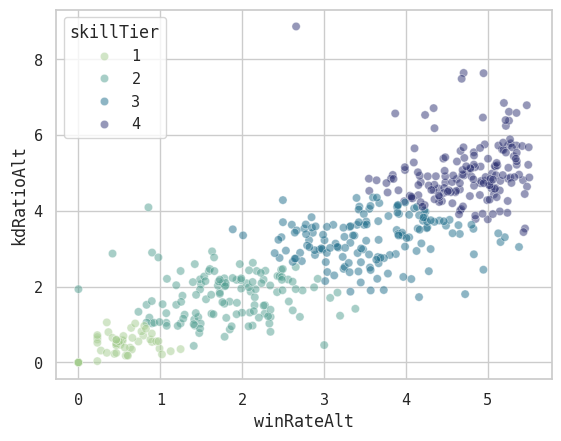

In [8]:
sns.scatterplot(data=df,
                x='winRateAlt',
                y='kdRatioAlt',
                color='#9090cc',
                alpha=0.5,
                hue = 'skillTier',
                palette='crest',
                marker='o')

## Classification

---

Based on the four classes derived above, we'll proceed to conduct multi-class classification.

> Because of the class imbalance, i.e, there are significantly more people in the lowest skill bracket compared to other brackets,
> we have to ensure that during `train_test_split`, we use the `stratify` option to preserve the class proportions in both the
> train and test sets. Additionally, in computing an overall metric to characterise the performance of a classifier, we have adopted
> the **F1 score**. This is computed as the harmonic mean of the precision and recall. The F1 scores are *macro-averaged* because
> while most models are great at classifying players who belong to the lowest skill tier, we want to acknowledge the deficiencies
> in classifying other skill tiers. If we were to use a weighted average, the resulting F1 score would be high regardless of the low
> F1 scores in the minority classes. Therefore we opted for the macro average instead.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [12]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'skillTier'

In [13]:
def model_evaluation_w_grid_search(df, predictors, target, model_instance, param_grid, cv):
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[[target]])

    pipeline = Pipeline([
        ('Standardization', StandardScaler()),
        ('PCA', PCA(n_components=3)),
        ('Classification', model_instance),
    ])
    
    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='f1_macro')
    model.fit(df_train[predictors], df_train[[target]])

    print('<<- Principal Component Analysis (Explained Variance) ->>\n')
    for c in range(model.best_estimator_["PCA"].n_components_):
        print(f'Component {c+1}: {model.best_estimator_["PCA"].explained_variance_ratio_[c]*100:05.2f}%')
    print()

    print('<<- Grid Search Results (Best Parameters) ->>\n')
    for k, v in model.best_params_.items():
        if k[0:3] == 'PCA':
            print(f'n_components (PCA)\t{v}')
        else:
            print(f'{k[16:]:20}\t{v}')
    print()

    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])

    print('<<- Classification Report (Train Set) ->>\n')
    print(classification_report(df_train[[target]], pred_train, target_names=['1', '2', '3', '4']))
    print('<<- Classification Report (Test Set) ->>\n')
    print(classification_report(df_test[[target]], pred_test, target_names=['1', '2', '3', '4']))
    
    return f1_score(df_test[[target]], pred_test, average='macro')

In [14]:
model_performance = {}

In [15]:
param_grid = {
    'PCA__n_components':        [3, 6, 9],
    'Classification__penalty': ['l1', 'l2', 'elastinet'],
    'Classification__C':       [0.1, 1, 10, 100],
    'Classification__solver':  ['lbfgs', 'lib_linear']
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=LogisticRegression(),
    param_grid=param_grid,
    cv=3
)

model_performance['LogisticRegression'] = f1

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.31%
Component 2: 14.09%
Component 3: 12.40%
Component 4: 06.04%
Component 5: 04.38%
Component 6: 02.00%
Component 7: 01.16%
Component 8: 00.54%
Component 9: 00.08%

<<- Grid Search Results (Best Parameters) ->>

C                   	10
penalty             	l2
solver              	lbfgs
n_components (PCA)	9

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       0.98      0.99      0.99       469
           2       0.88      0.88      0.88       104
           3       0.89      0.84      0.86       120
           4       0.92      0.94      0.93       131

    accuracy                           0.95       824
   macro avg       0.92      0.91      0.91       824
weighted avg       0.95      0.95      0.95       824

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.98      1.00      0.

In [22]:
param_grid = {
    'PCA__n_components':        [3, 6, 9],
    'Classification__tol':      [1e-4, 1e-3, 1e-2, 1e-1],
    'Classification__C':        [0.1, 1, 10, 100],
    'Classification__max_iter': [-1, 1_000, 10_000]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVC(),
    param_grid=param_grid,
    cv=3
)

model_performance['SVC'] = f1

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.83%
Component 2: 13.62%
Component 3: 12.55%
Component 4: 05.82%
Component 5: 04.35%
Component 6: 02.09%
Component 7: 01.09%
Component 8: 00.56%
Component 9: 00.08%

<<- Grid Search Results (Best Parameters) ->>

C                   	10
max_iter            	-1
tol                 	0.0001
n_components (PCA)	9

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       469
           2       0.91      0.89      0.90       104
           3       0.92      0.91      0.92       120
           4       0.96      0.97      0.97       131

    accuracy                           0.96       824
   macro avg       0.95      0.94      0.94       824
weighted avg       0.96      0.96      0.96       824

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.97      0.98      0

In [23]:
param_grid = {
    'PCA__n_components':           [3, 6, 9],
    'Classification__n_neighbors': [5, 10, 15, 20, 25],
    'Classification__algorithm':   ['ball_tree', 'kd_tree', 'brute'],
    'Classification__leaf_size':   [5, 10, 15, 20, 25]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['KNeighborsClassifier'] = f1

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.83%
Component 2: 13.53%
Component 3: 12.58%
Component 4: 06.06%
Component 5: 04.20%
Component 6: 02.02%
Component 7: 01.14%
Component 8: 00.55%
Component 9: 00.08%

<<- Grid Search Results (Best Parameters) ->>

algorithm           	ball_tree
leaf_size           	5
n_neighbors         	5
n_components (PCA)	9

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       469
           2       0.85      0.93      0.89       104
           3       0.88      0.86      0.87       120
           4       0.90      0.92      0.91       131

    accuracy                           0.94       824
   macro avg       0.90      0.92      0.91       824
weighted avg       0.94      0.94      0.94       824

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.98      0.92      

In [24]:
param_grid = {
    'PCA__n_components':            [3, 6, 9],
    'Classification__criterion':    ['gini', 'entropy', 'log_loss'],
    'Classification__max_depth':    [None, 5, 10, 15],
    'Classification__max_features': [None, 'sqrt', 'log2']
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['DecisionTreeClassifier'] = f1

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.32%
Component 2: 13.61%
Component 3: 12.14%
Component 4: 06.03%
Component 5: 04.25%
Component 6: 01.97%
Component 7: 01.03%
Component 8: 00.57%
Component 9: 00.08%

<<- Grid Search Results (Best Parameters) ->>

criterion           	entropy
max_depth           	None
max_features        	None
n_components (PCA)	9

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       469
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       131

    accuracy                           1.00       824
   macro avg       1.00      1.00      1.00       824
weighted avg       1.00      1.00      1.00       824

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.95      1.00  

In [25]:
param_grid = {
    'PCA__n_components':             [3, 6, 9],
    'Classification__criterion':     ['gini', 'entropy', 'log_loss'],
    'Classification__max_depth':     [None, 5, 10, 15],
    'Classification__n_estimators':  [50, 100, 150]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['RandomForestClassifier'] = f1

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.21%
Component 2: 13.58%
Component 3: 12.18%
Component 4: 06.16%
Component 5: 04.12%
Component 6: 02.07%
Component 7: 01.09%
Component 8: 00.51%
Component 9: 00.08%

<<- Grid Search Results (Best Parameters) ->>

criterion           	log_loss
max_depth           	15
n_estimators        	150
n_components (PCA)	9

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       469
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       131

    accuracy                           1.00       824
   macro avg       1.00      1.00      1.00       824
weighted avg       1.00      1.00      1.00       824

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.95      0.97    

In [26]:
param_grid = {
    'PCA__n_components':             [3, 6, 9],
    'Classification__learning_rate': [0.1, 0.5],
    'Classification__n_estimators':  [50, 100, 150]
}

f1 = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingClassifier(),
    param_grid=param_grid,
    cv=3
)

model_performance['GradientBoostingClassifier'] = f1

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.12%
Component 2: 13.73%
Component 3: 12.02%
Component 4: 06.14%
Component 5: 04.09%
Component 6: 02.10%
Component 7: 01.12%
Component 8: 00.60%
Component 9: 00.08%

<<- Grid Search Results (Best Parameters) ->>

learning_rate       	0.1
n_estimators        	100
n_components (PCA)	9

<<- Classification Report (Train Set) ->>

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       469
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       131

    accuracy                           1.00       824
   macro avg       1.00      1.00      1.00       824
weighted avg       1.00      1.00      1.00       824

<<- Classification Report (Test Set) ->>

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       118
           2

(0.0, 1.1480097172247437)

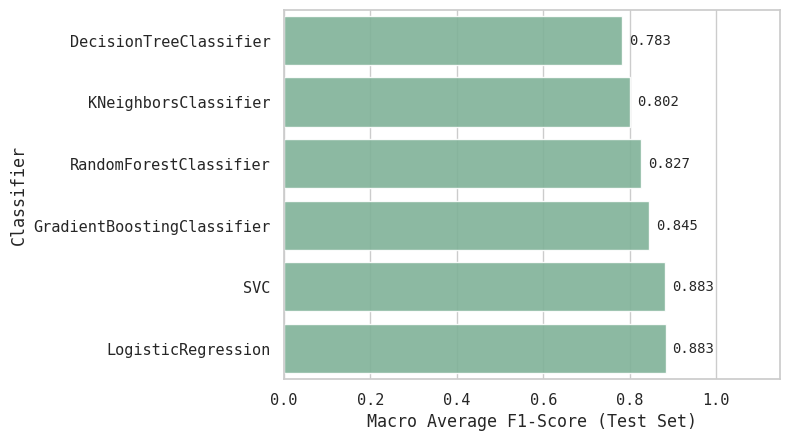

In [27]:
pairs = sorted((v, k) for k, v in model_performance.items())
result = {
    'Classifier': [pair[1] for pair in pairs],
    'Macro Average F1-Score (Test Set)': [pair[0] for pair in pairs]
}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='Macro Average F1-Score (Test Set)',
                 y='Classifier',
                 orient='y',
                 color='#78ba98',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.3f')
ax.set_xlim(0, result['Macro Average F1-Score (Test Set)'][-1] * 1.3)